<a href="https://colab.research.google.com/github/ThamilezaiAnanthakumar/Eye-State-Monitoring-using-EMG-artifact-as-useful-feature-in-EEG/blob/main/Biosignal_Analysis_2_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
!pip install wfdb numpy matplotlib scipy mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [2]:
%matplotlib inline
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import mne, scipy
import matplotlib.pyplot as plt
from pprint import pprint

# Download Datasets

In [3]:
# Download an example ECG record from PhysioNet MIT-BIH Arrhythmia Database
record_name = '100'  # Record 100 is a commonly used sample record
# Download record files (dat, hea, atr) from MIT-BIH Arrhythmia Database into 'mitdb' folder
wfdb.dl_database('mitdb', './mitdb', records=[record_name])


# Download an 60 channel EEG + MEG dataset from MNE
# https://mne.tools/stable/auto_tutorials/intro/10_overview.html

# Get the path to MNE's built-in sample dataset
sample_data_folder = mne.datasets.sample.data_path()

# Construct the full path to the raw EEG/MEG data file
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif"
)
# Load the raw data from the .fif file into an MNE Raw object
raw = mne.io.read_raw_fif(sample_data_raw_file)

Generating record list for: 100
Generating list of all files for: 100
Created local base download directory: ./mitdb
Finished downloading files
Using default location ~/mne_data for sample...
Creating /root/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.37TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 02m10s (1576.2 MB)
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


# Pan-Tompkins Algorithm

Loaded ECG record 100 with sampling frequency 360 Hz


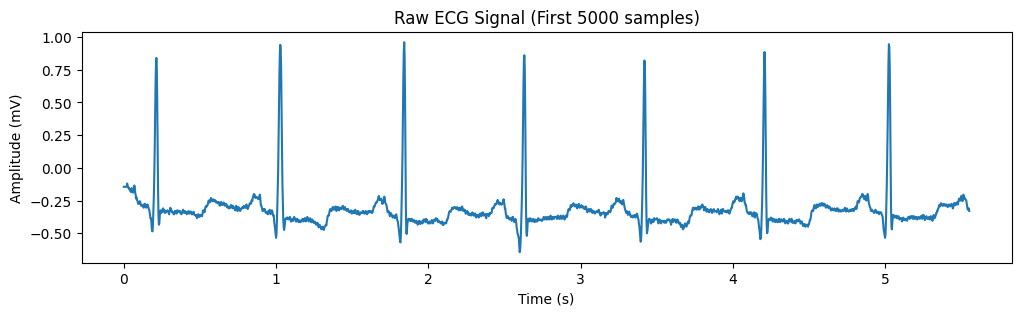

In [4]:
# Load the ECG signal and annotations
record = wfdb.rdrecord(f'./mitdb/{record_name}')
annotation = wfdb.rdann(f'./mitdb/{record_name}', 'atr')


ecg = record.p_signal[:,0] # Use channel 0 (MLII)
fs = record.fs
t = np.arange(len(ecg)) / fs

print(f"Loaded ECG record {record_name} with sampling frequency {fs} Hz")

# Plot raw ECG signal
plt.figure(figsize=(12,3))
plt.plot(t[:2000], ecg[:2000])
plt.title('Raw ECG Signal (First 5000 samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.show()

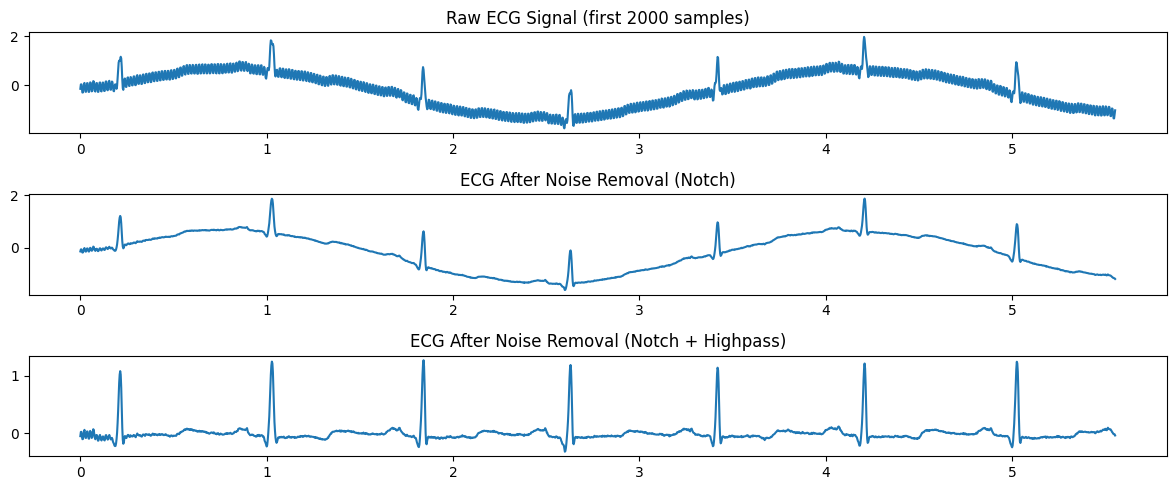

In [5]:
from scipy.signal import iirnotch, filtfilt, butter

noise_freq = 60.0  # line noise frequency in Hz
noise_freq2 = 0.3
noise_amplitude = 0.2  # adjust to taste (in mV)
noise_amplitude2 = 1

# Create synthetic sinusoidal noise
line_noise = noise_amplitude * np.sin(2 * np.pi * noise_freq * t)
drift_noise = noise_amplitude2 * np.sin(2 * np.pi * noise_freq2 * t)
# Add noise to ECG
ecg_noisy = ecg + line_noise + drift_noise

# Noise Removal Stage

# Notch filter to remove powerline interference at 60 Hz (or 50 Hz)
def notch_filter(signal, fs, freq=60.0, Q=30):
    # Q is quality factor, higher Q is narrower notch
    b, a = iirnotch(freq/(fs/2), Q)
    filtered = filtfilt(b, a, signal)
    return filtered

# High-pass filter to remove baseline wander (cutoff ~0.5 Hz)
def highpass_filter(signal, cutoff=0.5, fs=360, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high')
    filtered = filtfilt(b, a, signal)
    return filtered

# Apply notch filter first
ecg_notch = notch_filter(ecg_noisy, fs, freq=60.0, Q=30)

# Apply highpass filter next
ecg_denoised = highpass_filter(ecg_notch, cutoff=1, fs=fs)

# Plot before and after noise removal
plt.figure(figsize=(12,5))
plt.subplot(3,1,1)
plt.plot(t[:2000], ecg_noisy[:2000])
plt.title('Raw ECG Signal (first 2000 samples)')
plt.subplot(3,1,2)
plt.plot(t[:2000], ecg_notch[:2000])
plt.title('ECG After Noise Removal (Notch)')
plt.subplot(3,1,3)
plt.plot(t[:2000], ecg_denoised[:2000])
plt.title('ECG After Noise Removal (Notch + Highpass)')
plt.tight_layout()
plt.show()

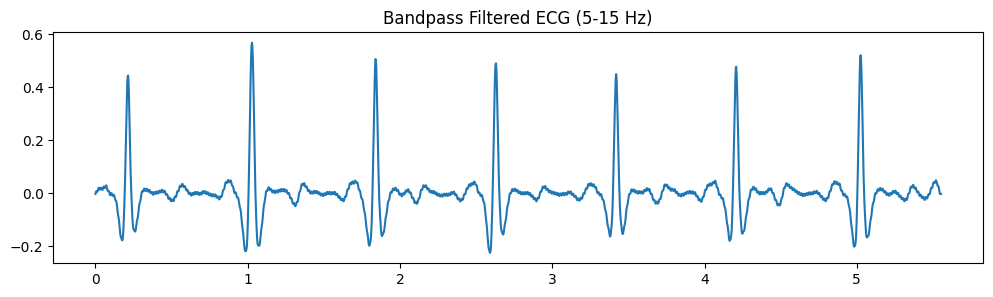

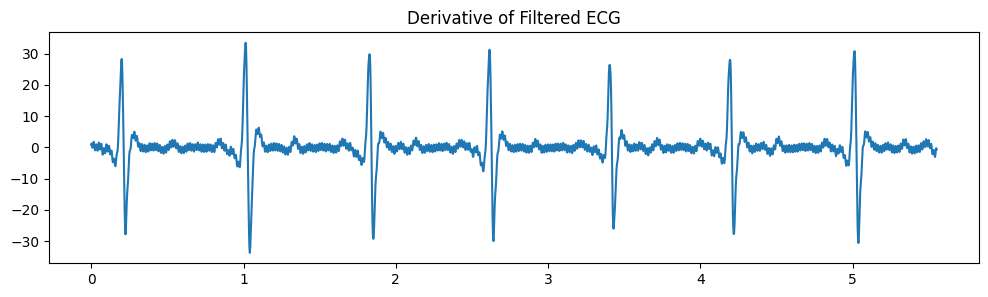

In [6]:
# === Pan-Tompkins Algorithm Implementation ===

# 1. Bandpass filter (5-15 Hz approx) to reduce noise and baseline wander
def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b,a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b,a,signal)
    return filtered

filtered_ecg = bandpass_filter(ecg_noisy, 5, 15, fs)

plt.figure(figsize=(12,3))
plt.plot(t[:2000], filtered_ecg[:2000])
plt.title('Bandpass Filtered ECG (5-15 Hz)')
plt.show()

# 2. Derivative filter to highlight QRS slopes
# Approximate derivative filter given in the Pan-Tompkins paper.
derivative_filter = np.array([1, 2, 0, -2, -1]) * (fs / 8.0)
derivative_ecg = np.convolve(filtered_ecg, derivative_filter, mode='same')

plt.figure(figsize=(12,3))
plt.plot(t[:2000], derivative_ecg[:2000])
plt.title('Derivative of Filtered ECG')
plt.show()

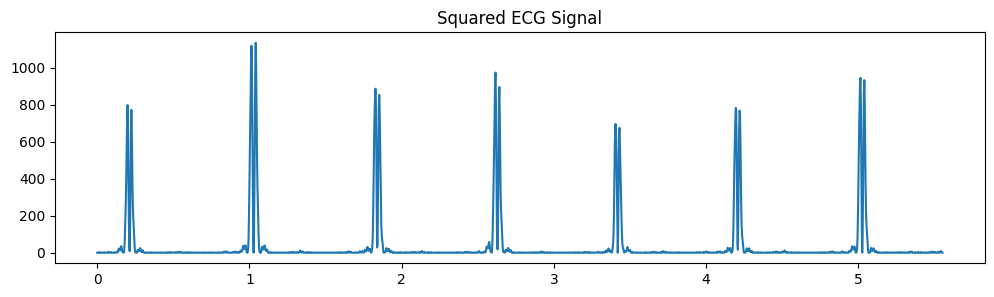

In [7]:
# 3. Squaring to make all data points positive and emphasize large differences
squared_ecg = derivative_ecg ** 2

plt.figure(figsize=(12,3))
plt.plot(t[:2000], squared_ecg[:2000])
plt.title('Squared ECG Signal')
plt.show()

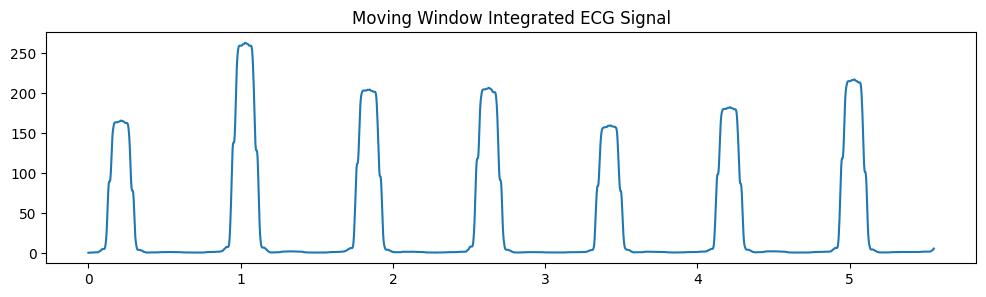

In [8]:
# 4. Moving Window Integration to extract waveform features
window_size = int(0.150 * fs)  # 150 ms window

def moving_window_integration(signal, window_size):
    window = np.ones(window_size) / window_size
    integrated = np.convolve(signal, window, mode='same')
    return integrated

integrated_ecg = moving_window_integration(squared_ecg, window_size)

plt.figure(figsize=(12,3))
plt.plot(t[:2000], integrated_ecg[:2000])
plt.title('Moving Window Integrated ECG Signal')
plt.show()

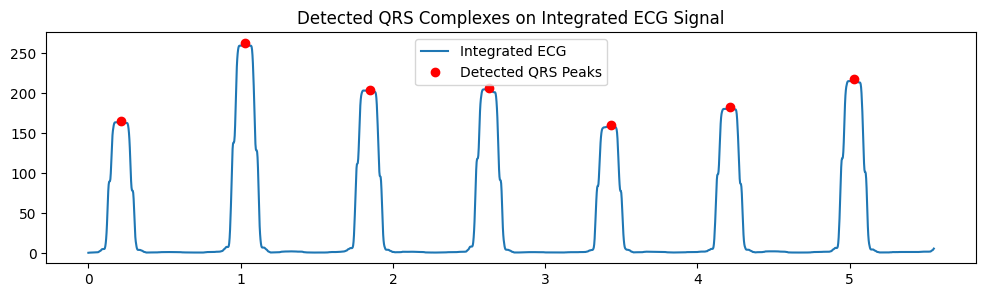

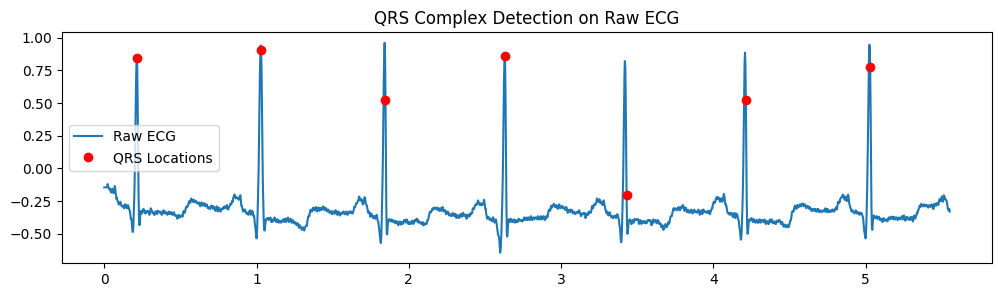

Detected 2273 QRS complexes in the first 2000 samples.


In [9]:
# 5. Peak detection on integrated signal to find QRS complexes
# Thresholding and refractory period applied for basic QRS detection
min_distance = int(0.2 * fs)  # Minimum distance between peaks ~200ms

peaks, _ = find_peaks(integrated_ecg, distance=min_distance, height=np.mean(integrated_ecg)*1.2)

plt.figure(figsize=(12,3))
plt.plot(t[:2000], integrated_ecg[:2000], label='Integrated ECG')
plt.plot(t[peaks[peaks < 2000]], integrated_ecg[peaks[peaks < 2000]], 'ro', label='Detected QRS Peaks')
plt.title('Detected QRS Complexes on Integrated ECG Signal')
plt.legend()
plt.show()

# Mark detected QRS on original ECG
plt.figure(figsize=(12,3))
plt.plot(t[:2000], ecg[:2000], label='Raw ECG')
plt.plot(t[peaks[peaks < 2000]], ecg[peaks[peaks < 2000]], 'ro', label='QRS Locations')
plt.title('QRS Complex Detection on Raw ECG')
plt.legend()
plt.show()

print(f"Detected {len(peaks)} QRS complexes in the first 2000 samples.")

# Investigate the Raw EEG

Channels
0-10: ['MEG 0113', 'MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123', 'MEG 0121', 'MEG 0132', 'MEG 0133', 'MEG 0131', 'MEG 0143']
10-20: ['MEG 0142', 'MEG 0141', 'MEG 0213', 'MEG 0212', 'MEG 0211', 'MEG 0222', 'MEG 0223', 'MEG 0221', 'MEG 0232', 'MEG 0233']
20-30: ['MEG 0231', 'MEG 0243', 'MEG 0242', 'MEG 0241', 'MEG 0313', 'MEG 0312', 'MEG 0311', 'MEG 0322', 'MEG 0323', 'MEG 0321']
30-40: ['MEG 0333', 'MEG 0332', 'MEG 0331', 'MEG 0343', 'MEG 0342', 'MEG 0341', 'MEG 0413', 'MEG 0412', 'MEG 0411', 'MEG 0422']
40-50: ['MEG 0423', 'MEG 0421', 'MEG 0432', 'MEG 0433', 'MEG 0431', 'MEG 0443', 'MEG 0442', 'MEG 0441', 'MEG 0513', 'MEG 0512']
50-60: ['MEG 0511', 'MEG 0523', 'MEG 0522', 'MEG 0521', 'MEG 0532', 'MEG 0533', 'MEG 0531', 'MEG 0542', 'MEG 0543', 'MEG 0541']
60-70: ['MEG 0613', 'MEG 0612', 'MEG 0611', 'MEG 0622', 'MEG 0623', 'MEG 0621', 'MEG 0633', 'MEG 0632', 'MEG 0631', 'MEG 0642']
70-80: ['MEG 0643', 'MEG 0641', 'MEG 0713', 'MEG 0712', 'MEG 0711', 'MEG 0723', 'MEG 0722', 'MEG

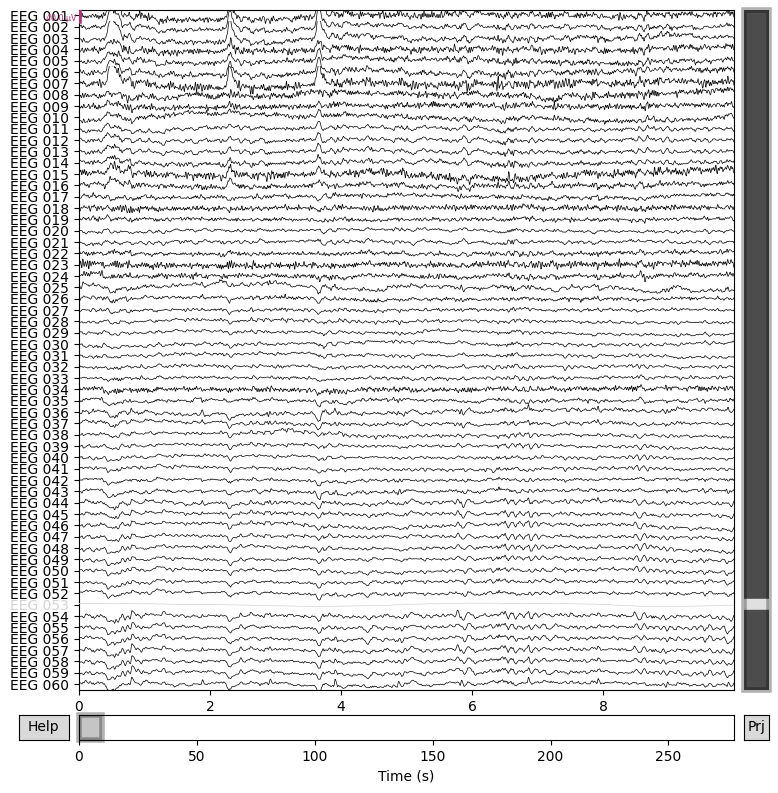

In [10]:
# Print the label "Channels" to indicate what is being listed
# There are MEG, EEG and EOG channels
print('Channels')


# Loop through channel names in groups of 10 for easier readability
for i in range(int(len(raw.info['ch_names']) / 10) + 1):
    # Print the index range and the corresponding channel names
    print(f'{i*10}-{(i+1)*10}: {raw.info["ch_names"][i*10:(i+1)*10]}')

# Plot the EEG channels from the raw data
# duration=10: display 10 seconds of data at a time
# picks="eeg": show only EEG channels
# n_channels=60: number of channels to display in the plot
raw.plot(duration=10, picks="eeg", n_channels=60);

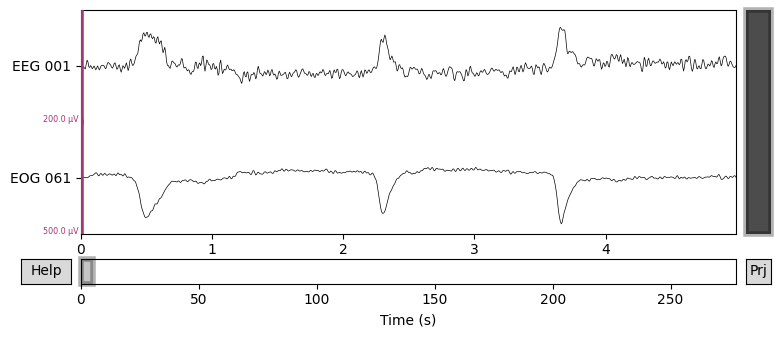

In [11]:
# EOG channels capture the eye blinks and eye movements
# However, eye blinks also appear as artifacts on EEG channels (e.g., on EEG 001)

# Create a plot of selected channels ("EEG 001" and "EOG 061") from the raw data
# duration=5: show 5 seconds of data
# show=False: prevent immediate display (to allow figure customization)
# scalings: set custom vertical scaling for EEG (100 µV) and EOG (250 µV)
fig = raw.plot(duration=5, picks=["EEG 001", "EOG 061"], show=False, scalings=dict(eeg=100e-6, eog=250e-6))

# Adjust the figure size for better visibility (width=8 inches, height=3 inches)
fig.set_size_inches(8, 3)

# Display the customized plot
plt.show()

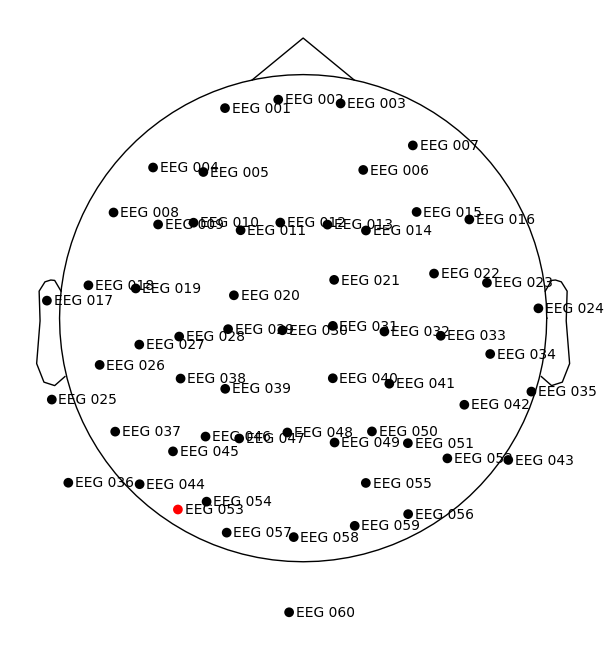

In [12]:
# Make a copy of the raw data to avoid modifying the original object
raw_eeg = raw.copy()

# Keep only EEG channels in the copied data
raw_eeg = raw_eeg.pick('eeg')

# Plot the spatial layout of EEG sensors
# show_names=True: label each sensor with its name
raw_eeg.plot_sensors(show_names=True);

bad channels = ['MEG 2443', 'EEG 053']


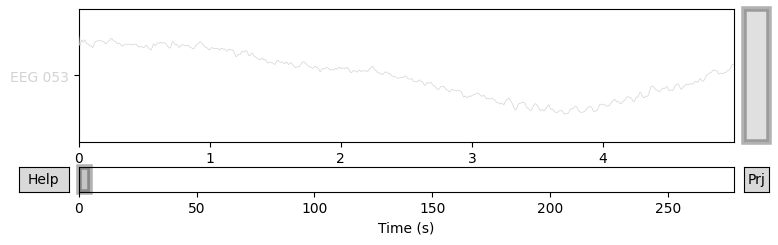

In [13]:
# EEG 053 is a BAD channel
print('bad channels =', raw.info['bads'])

# Plot a single EEG channel ("EEG 053") for 5 seconds
# show=False: don't display immediately (so we can adjust the figure size)
# scalings: set EEG vertical scaling to 10 µV for clearer detail
fig = raw.plot(duration=5, picks=["EEG 053"], show=False, scalings=dict(eeg=10e-6))

# Adjust the figure size (width=8 inches, height=2 inches)
fig.set_size_inches(8, 2)

# Display the customized plot
plt.show()

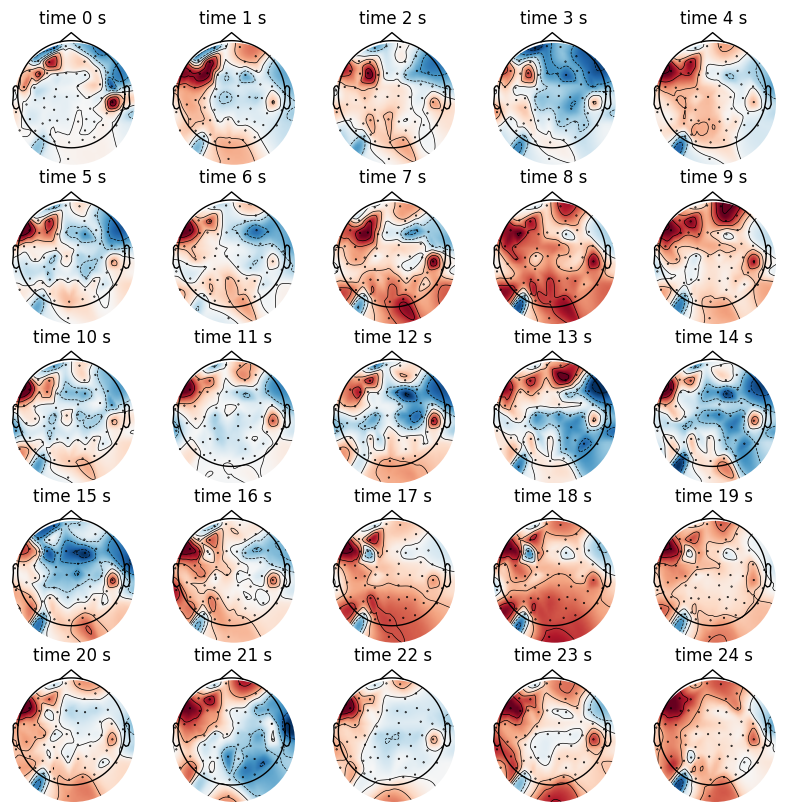

In [14]:
# We can visualize the changes over the channels using Topomaps

# Extract all EEG data and corresponding time points
data, times = raw_eeg[:, :]

# Get the sampling frequency of the recording
sfreq = raw.info['sfreq']

# Create a 5x5 grid of subplots for displaying topographic maps
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

# Loop through 25 time points (1-second intervals)
for i in range(25):
    ax = axs.flatten()[i]  # Get the subplot axis
    # Plot the scalp topomap at the given time point (i seconds)
    mne.viz.plot_topomap(data[:, int(i * sfreq)], raw_eeg.info, show=False, axes=ax)
    ax.set_title(f'time {i} s')  # Add a title showing the time in seconds

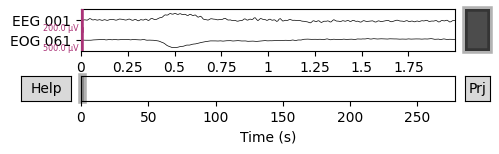

Text(0.5, 1.0, 'No eyeblink 0.8 s')

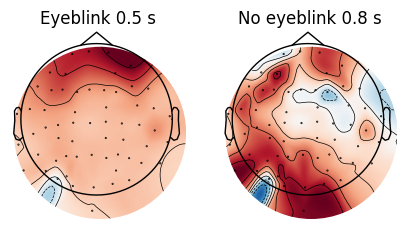

In [15]:
# Eyeblink artifacts can also be identified using Topomaps
# Eyeblink Topomaps have a lot of energy at the front

# Plot EEG channel "EEG 001" and EOG channel "EOG 061" for 2 seconds
fig = raw.plot(duration=2, picks=["EEG 001", "EOG 061"], show=False, scalings=dict(eeg=100e-6, eog=250e-6))

# Adjust figure size (width=5 inches, height=1 inch)
fig.set_size_inches(5, 1)
plt.show()

# Extract EEG data as a NumPy array
data = raw_eeg.get_data()

# Get the sampling frequency
sfreq = raw_eeg.info['sfreq']

# Create a figure with 1 row and 2 columns for topographic plots
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

# Plot topomap at 0.5 seconds (eyeblink present)
mne.viz.plot_topomap(data[:, int(0.5*sfreq)], raw_eeg.info, show=False, axes=axs[0])
axs[0].set_title('Eyeblink 0.5 s')

# Plot topomap at 0.8 seconds (no eyeblink)
mne.viz.plot_topomap(data[:, int(0.8*sfreq)], raw_eeg.info, show=False, axes=axs[1])
axs[1].set_title('No eyeblink 0.8 s')

Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


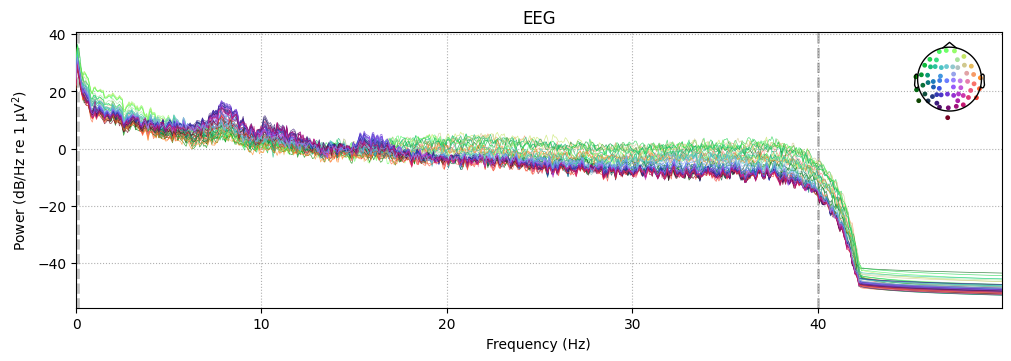

In [16]:
# Compute the Power Spectral Density (PSD) of the EEG data
# fmax=50: limit analysis to 0-50 Hz frequency range
raw_psd = raw_eeg.compute_psd(fmax=50)

# Plot the PSD
# picks="data": include all data channels
# exclude="bads": exclude any channels marked as bad
# amplitude=False: plot power spectral density (not amplitude)
raw_psd.plot(picks="data", exclude="bads", amplitude=False);

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 249 samples (1.658 s)

Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


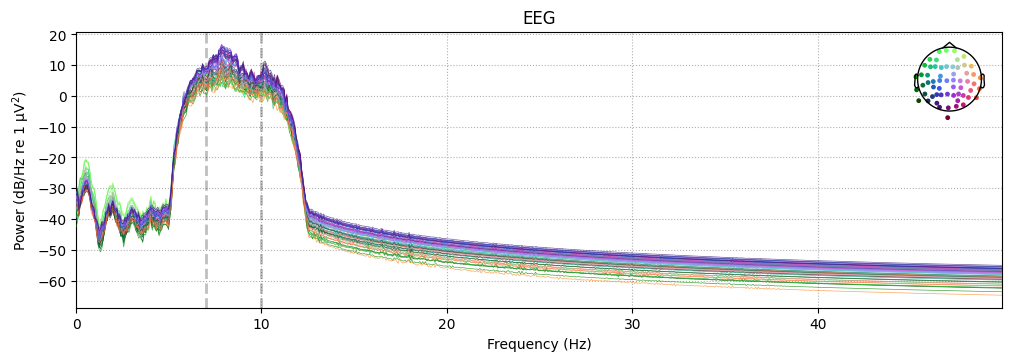

In [17]:
# Load the raw EEG data into memory for processing
raw_eeg.load_data()

# Make a copy of the raw EEG data and apply a band-pass filter between 7-10 Hz
eeg_filt = raw_eeg.copy().filter(7, 10)

# Compute the Power Spectral Density (PSD) of the filtered EEG
# fmax=50: consider frequencies up to 50 Hz
eeg_filt_psd = eeg_filt.compute_psd(fmax=50)

# Plot the PSD of the filtered EEG
# picks="data": include all data channels
# exclude="bads": ignore channels marked as bad
# amplitude=False: display power spectral density rather than amplitude
eeg_filt_psd.plot(picks="data", exclude="bads", amplitude=False);

Text(0.5, 1.0, 'Filtered EEG')

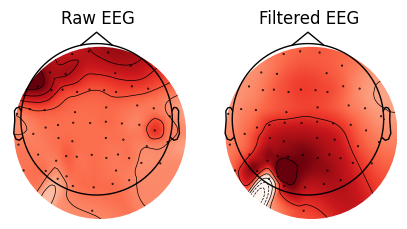

In [18]:
# Create a figure with 1 row and 2 columns for topographic RMS plots
fig, axs = plt.subplots(1, 2, figsize=(5, 3))

# Compute the RMS (root mean square) of raw EEG data across time for each channel
rms_raw = np.sqrt(np.mean(data**2, axis=1))

# Plot the RMS topomap of raw EEG
mne.viz.plot_topomap(rms_raw, raw_eeg.info, show=False, axes=axs[0])
axs[0].set_title('Raw EEG')

# Compute the RMS of the filtered EEG data across time for each channel
rms_filt = np.sqrt(np.mean(eeg_filt.get_data()**2, axis=1))

# Plot the RMS topomap of filtered EEG
mne.viz.plot_topomap(rms_filt, raw_eeg.info, show=False, axes=axs[1])
axs[1].set_title('Filtered EEG')

# Remove artifacts (ICA)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.3s.


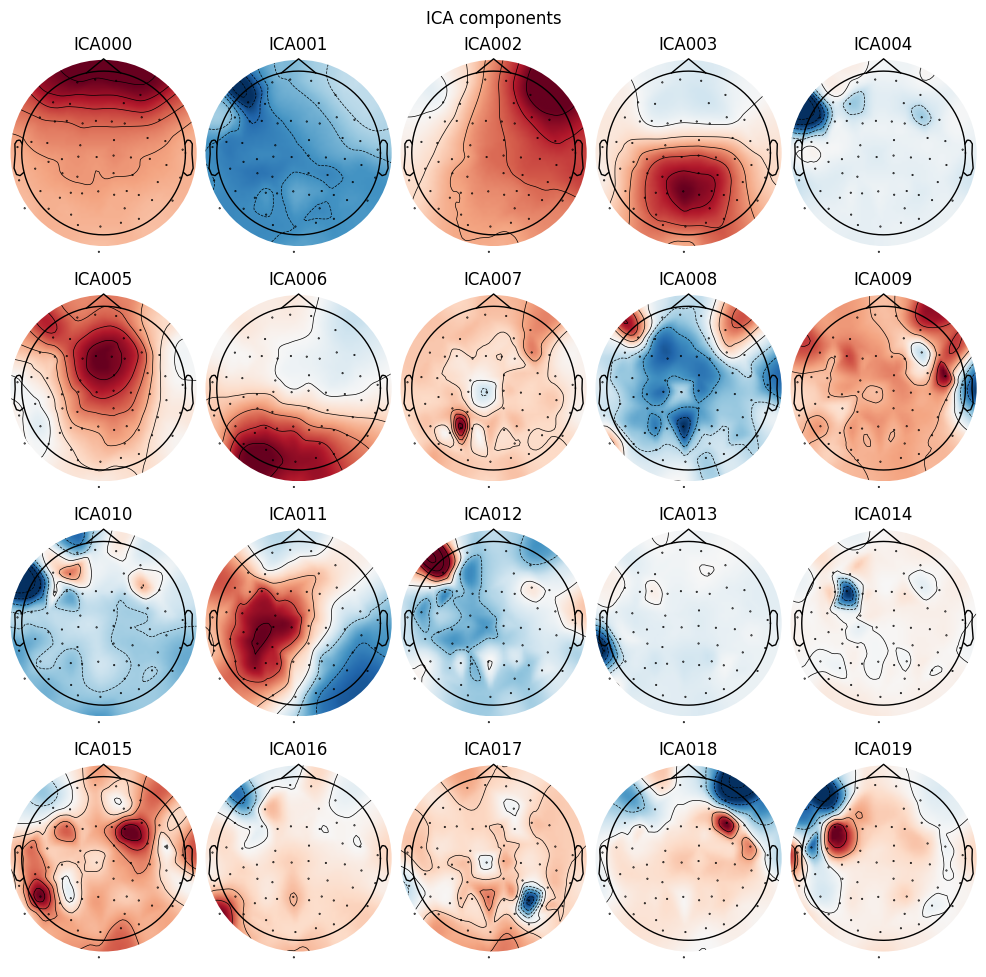

In [19]:
# Initialize an ICA object to decompose EEG data into 20 components
# n_components=20: number of independent components to extract
# random_state=97: ensures reproducibility
# max_iter=800: maximum iterations for convergence
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)

# Fit the ICA model to the raw EEG data
ica.fit(raw_eeg)

# Plot the spatial topographies of the 20 independent components
ica.plot_components();

Creating RawArray with float64 data, n_channels=4, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


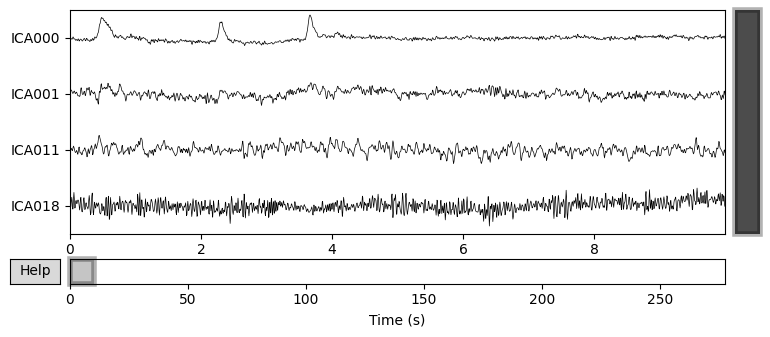

In [20]:
# Plot the time courses of selected ICA components (0, 1, 11, 18) from raw EEG
# stop=10.0: display only the first 10 seconds of data
# show=False: prevent immediate display (can customize figure later)
fig = ica.plot_sources(raw_eeg, picks=[0, 1, 11, 18], stop=10.0, show=False)
fig.set_size_inches(8, 3)
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components


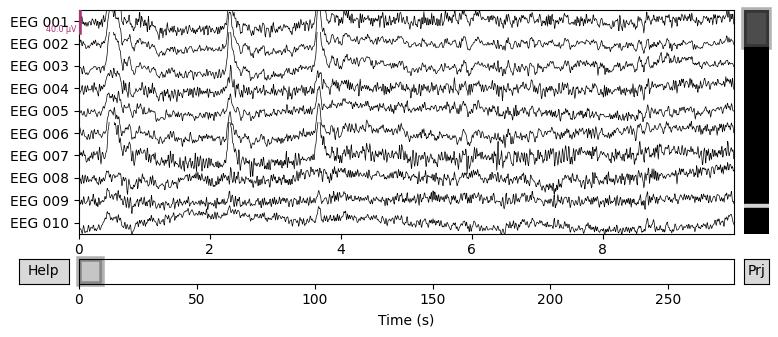

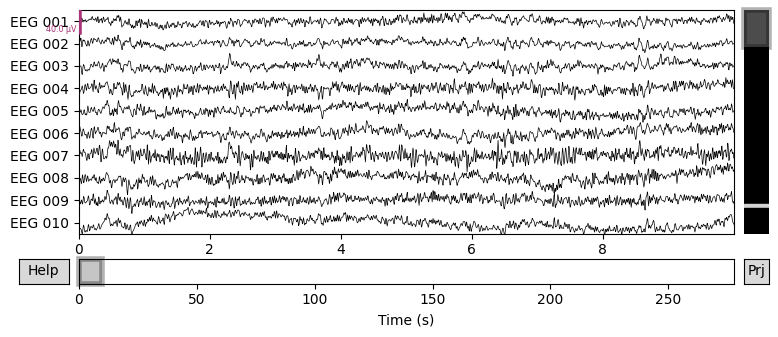

In [21]:
# Mark ICA component 0 for exclusion (e.g., artifact removal)
ica.exclude = [0]

# Load the raw EEG data into memory and make a copy for ICA application
eeg_ica = raw_eeg.load_data().copy()

# Apply the ICA solution to remove the excluded component from the EEG data
ica.apply(eeg_ica)

# Plot the original raw EEG for comparison
fig = raw_eeg.plot(duration=10, n_channels=10, show=False)
fig.set_size_inches(8, 3)
plt.show()

# Plot the EEG after ICA cleaning to visualize artifact removal
fig = eeg_ica.plot(duration=10, n_channels=10, show=False)
fig.set_size_inches(8, 3)
plt.show()

(-0.0001, 0.0001)

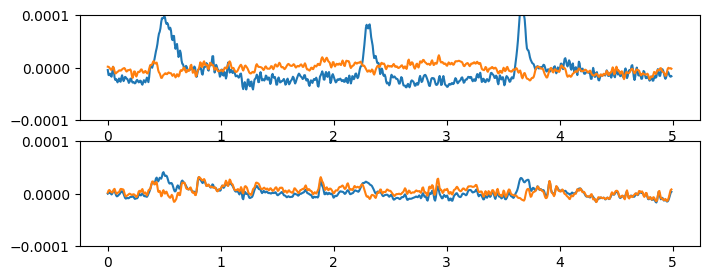

In [22]:
# Extract all data and time points from ICA-cleaned EEG
data_ica, times = eeg_ica[:, :]

# Extract the original EEG data for comparison
data = raw.copy().pick('eeg').get_data()

# Create a figure with 2 rows for comparing original vs ICA-cleaned signals
fig, axs = plt.subplots(2, 1, figsize=(8, 3))

# Define time indices for the first 5 seconds
t1 = int(0 * sfreq)
t2 = int(5 * sfreq)

# Plot original and ICA-cleaned signals for channel 0
axs[0].plot(times[t1:t2], data[0, t1:t2])
axs[0].plot(times[t1:t2], data_ica[0, t1:t2])
axs[0].set_ylim([-1e-4, 1e-4])  # Set consistent y-axis limits

# Plot original and ICA-cleaned signals for channel 35
axs[1].plot(times[t1:t2], data[35, t1:t2])
axs[1].plot(times[t1:t2], data_ica[35, t1:t2])
axs[1].set_ylim([-1e-4, 1e-4])  # Set consistent y-axis limits

# Evoked responses

In [23]:
# Detect events/triggers in the raw data from the stimulation channel "STI 014"
events = mne.find_events(raw, stim_channel="STI 014")

# Print the first 5 detected events to inspect their sample indices and event IDs
print(events[:5])

Finding events on: STI 014
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


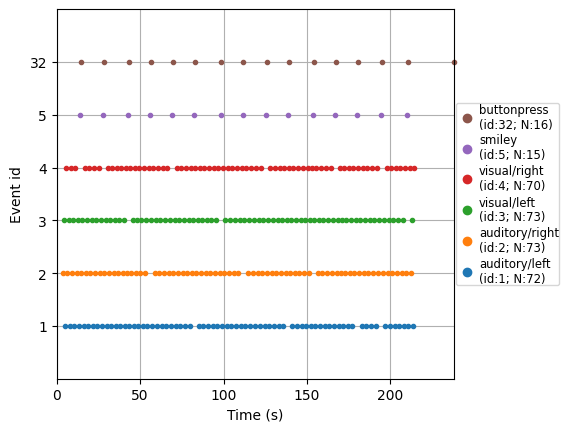

In [24]:
# Define a dictionary mapping event names to their corresponding trigger IDs
event_dict = {
    "auditory/left": 1,    # Left auditory stimulus
    "auditory/right": 2,   # Right auditory stimulus
    "visual/left": 3,      # Left visual stimulus
    "visual/right": 4,     # Right visual stimulus
    "smiley": 5,           # Smiley face stimulus
    "buttonpress": 32,     # Participant button press
}
# Plot the detected events as a timeline
# events: array of event onset samples
# event_id: dictionary mapping event names to IDs
# sfreq: sampling frequency of the recording
# first_samp: first sample index of the raw data
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)



In [25]:
# Create epochs (segments of EEG data around each event) from the ICA-cleaned EEG
# eeg_ica: ICA-cleaned raw EEG data
# events: array of event onset samples
# event_id: dictionary mapping event names to trigger IDs
# tmin=-0.2, tmax=0.5: epoch window from 200 ms before to 500 ms after the event
# reject: exclude epochs with EEG amplitude exceeding 150 µV to remove artifacts
# preload=True: load all epoch data into memory for faster subsequent analysis
epochs = mne.Epochs(
    eeg_ica,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=dict(eeg=150e-6),
    preload=True,
)

# Display a summary of the created Epochs object
epochs

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 008']
1 bad epochs dropped


<Epochs | 318 events (all good), -0.2 – 0.499 s (baseline -0.2 – 0 s), ~18.4 MiB, data loaded,
 'auditory/left': 72
 'auditory/right': 73
 'visual/left': 73
 'visual/right': 70
 'smiley': 14
 'buttonpress': 16>

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


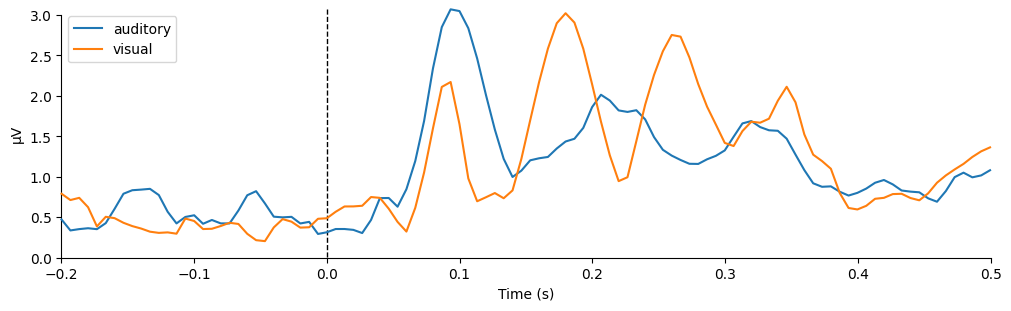

In [26]:
# Select subsets of epochs based on event type
aud_epochs = epochs["auditory"]      # All auditory stimulus epochs
vis_epochs = epochs["visual"]        # All visual stimulus epochs
but_epochs = epochs["buttonpress"]   # All button press epochs

# Compute the average (evoked response) for each condition
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()
but_evoked = but_epochs.average()

# Plot and compare the evoked responses for auditory and visual stimuli
# legend="upper left": place legend in the upper left corner
# show=False: prevent immediate display to allow figure resizing
fig = mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left", show=False,
)

# Set the figure size for better visibility
fig[0].set_size_inches(10, 3)
plt.show()

Projections have already been applied. Setting proj attribute to True.


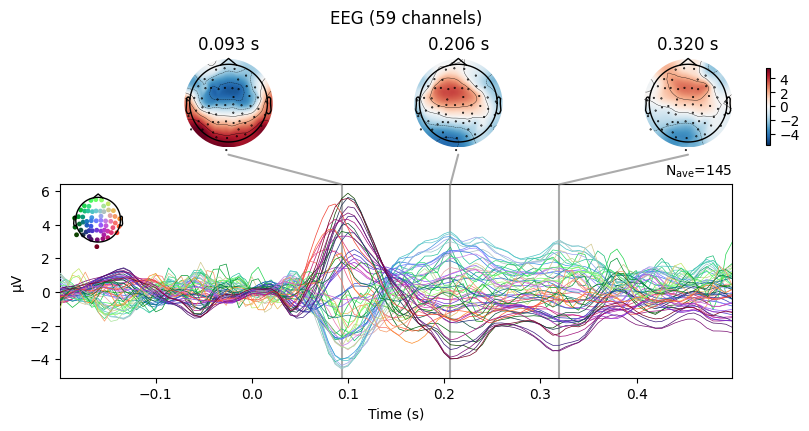

Projections have already been applied. Setting proj attribute to True.


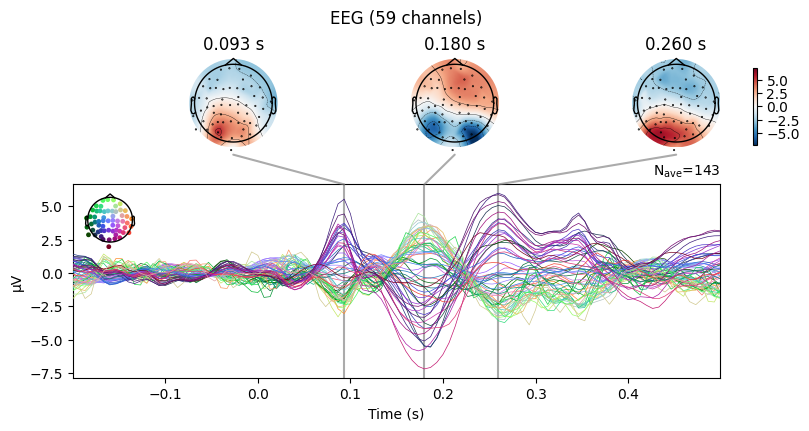

In [27]:
# Plot joint representations of auditory evoked response
# Combines time series, topographies, and global field power in one figure
aud_evoked.plot_joint()

# Plot joint representations of visual evoked response
vis_evoked.plot_joint();

Projections have already been applied. Setting proj attribute to True.


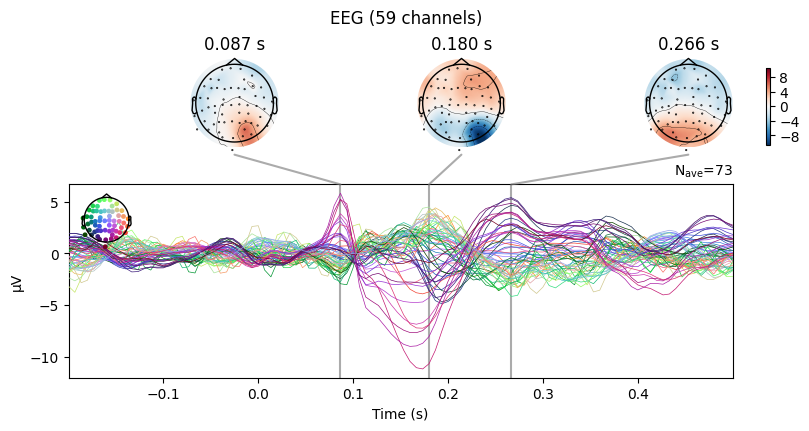

Projections have already been applied. Setting proj attribute to True.


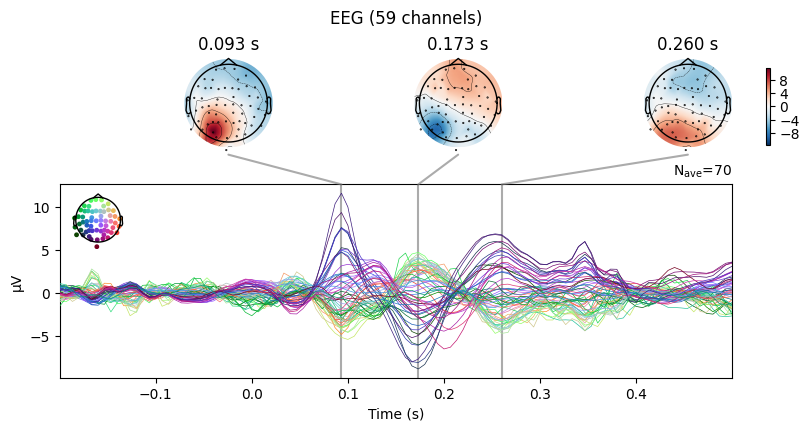

In [28]:
# Plot joint representation of visual left stimulus evoked response
vis_epochs['left'].average().plot_joint()

# Plot joint representation of visual right stimulus evoked response
vis_epochs['right'].average().plot_joint();